In [3]:
from io import StringIO

import matplotlib.pyplot as plt
from scipy.io import arff
import seaborn as sns
from loguru import logger
import yaml

from datetime import datetime
import polars as pl
import pandas as pd
import numpy as np
import os

# MODEL
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import (
    LabelEncoder, 
    StandardScaler,
    label_binarize
)
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_recall_fscore_support,
    balanced_accuracy_score,
    roc_auc_score,
    roc_curve
)

# Save variables for model
import joblib


# PERSONAL FUNCTIONS
from utils import *
from models.main import *
from functions.windows import create_feature_windows # creación de ventanas e ingenieria de características

**Nota:** Se determinó que el formato 'Timestamp' está en nanosegundos. Aunque se exploró con las otras métricas (microsegundos y milisegundos), ninguna coincidia con la frecuencia de muestreo de 20Hz se aproxima a 0.05 segundos.

In [2]:
# Cargar datos
path_base = r"F:\UPC\Tesis\HARbit-Model\src\data\wisdm-dataset\raw\watch"
sensor_data = load_sensors_separately(path_base)
df_gyro = sensor_data['gyro']
# df_gyro = df_gyro.rename({'X': 'X_gyro', 'Y': 'Y_gyro', 'Z': 'Z_gyro'})

df_accel = sensor_data['accel']
# df_accel = df_accel.rename({'X': 'X_accel', 'Y': 'Y_accel', 'Z': 'Z_accel'})

print(f"Giroscopio: {len(df_gyro)} muestras")
print(f"Acelerómetro: {len(df_accel)} muestras")

2025-09-22 21:02:53.880 | INFO     | utils.data_loading:load_sensors_separately:64 - Cargando datos de gyro...
2025-09-22 21:03:03.868 | INFO     | utils.data_loading:load_sensors_separately:64 - Cargando datos de accel...


Giroscopio: 3440341 muestras
Acelerómetro: 3777045 muestras


In [65]:
df_all_sensors = df_gyro.join(df_accel, on = ['Subject-id', 'Timestamp', 'Activity Label'], how = "inner")

In [66]:
df_gyro_inner = df_all_sensors.select(
    pl.col('Subject-id'),
    pl.col('Activity Label'),
    pl.col('Timestamp'),
    pl.col('X_gyro').alias('X'),
    pl.col('Y_gyro').alias('Y'),
    pl.col('Z_gyro').alias('Z')
)

In [67]:
df_accel_inner = df_all_sensors.select(
    pl.col('Subject-id'),
    pl.col('Activity Label'),
    pl.col('Timestamp'),
    pl.col('X_accel').alias('X'),
    pl.col('Y_accel').alias('Y'),
    pl.col('Z_accel').alias('Z')
)

In [3]:
with open(r'F:\UPC\Tesis\HARbit-Model\src\config\activities.yaml', 'r') as file:
    config = yaml.safe_load(file)['config']

In [ ]:
df_gyro_inner = df_gyro_inner.to_pandas()

In [ ]:
df_accel_inner = df_accel_inner.to_pandas()

In [71]:
activities_ = config['labels'] 
cluster_ = config['clusters']

df_gyro_inner['Activity Label'] = df_gyro_inner['Activity Label'].apply(lambda x: activities_[x])
df_accel_inner['Activity Label'] = df_accel_inner['Activity Label'].apply(lambda x: activities_[x])

for activity in cluster_.keys():
    for act in cluster_[activity]:
        df_gyro_inner.loc[df_gyro_inner['Activity Label'] == act, 'Activity Label'] = activity
        df_accel_inner.loc[df_accel_inner['Activity Label'] == act, 'Activity Label'] = activity

In [5]:
activities_ = config['labels']
cluster_ = config['clusters']

df_gyro = df_gyro.to_pandas()
df_accel = df_accel.to_pandas()

df_gyro['Activity Label']   = df_gyro['Activity Label'].apply(lambda x: activities_[x])
df_accel['Activity Label']  = df_accel['Activity Label'].apply(lambda x: activities_[x])

for activity in cluster_.keys():
    for act in cluster_[activity]:
        df_gyro.loc[df_gyro['Activity Label'] == act, 'Activity Label'] = activity
        df_accel.loc[df_accel['Activity Label'] == act, 'Activity Label'] = activity

In [63]:
stats_summary = pl.DataFrame(df_accel_inner).group_by(['Subject-id', 'Activity Label']).agg([
    # Estadísticas básicas
    pl.col('X').min().alias('X_min'),
    pl.col('X').max().alias('X_max'),
    pl.col('X').mean().alias('X_mean'),
    
    pl.col('Y').min().alias('Y_min'),
    pl.col('Y').max().alias('Y_max'),
    pl.col('Y').mean().alias('Y_mean'),
    
    pl.col('Z').min().alias('Z_min'),
    pl.col('Z').max().alias('Z_max'),
    pl.col('Z').mean().alias('Z_mean'),
]).sort(['Subject-id', 'Activity Label'])

print("📊 ESTADÍSTICAS COMPLETAS POR USUARIO-ACTIVIDAD:")
stats_summary.write_excel(r"C:\Users\HP\Downloads\stats_summary_accel_wisdm.xlsx")

📊 ESTADÍSTICAS COMPLETAS POR USUARIO-ACTIVIDAD:


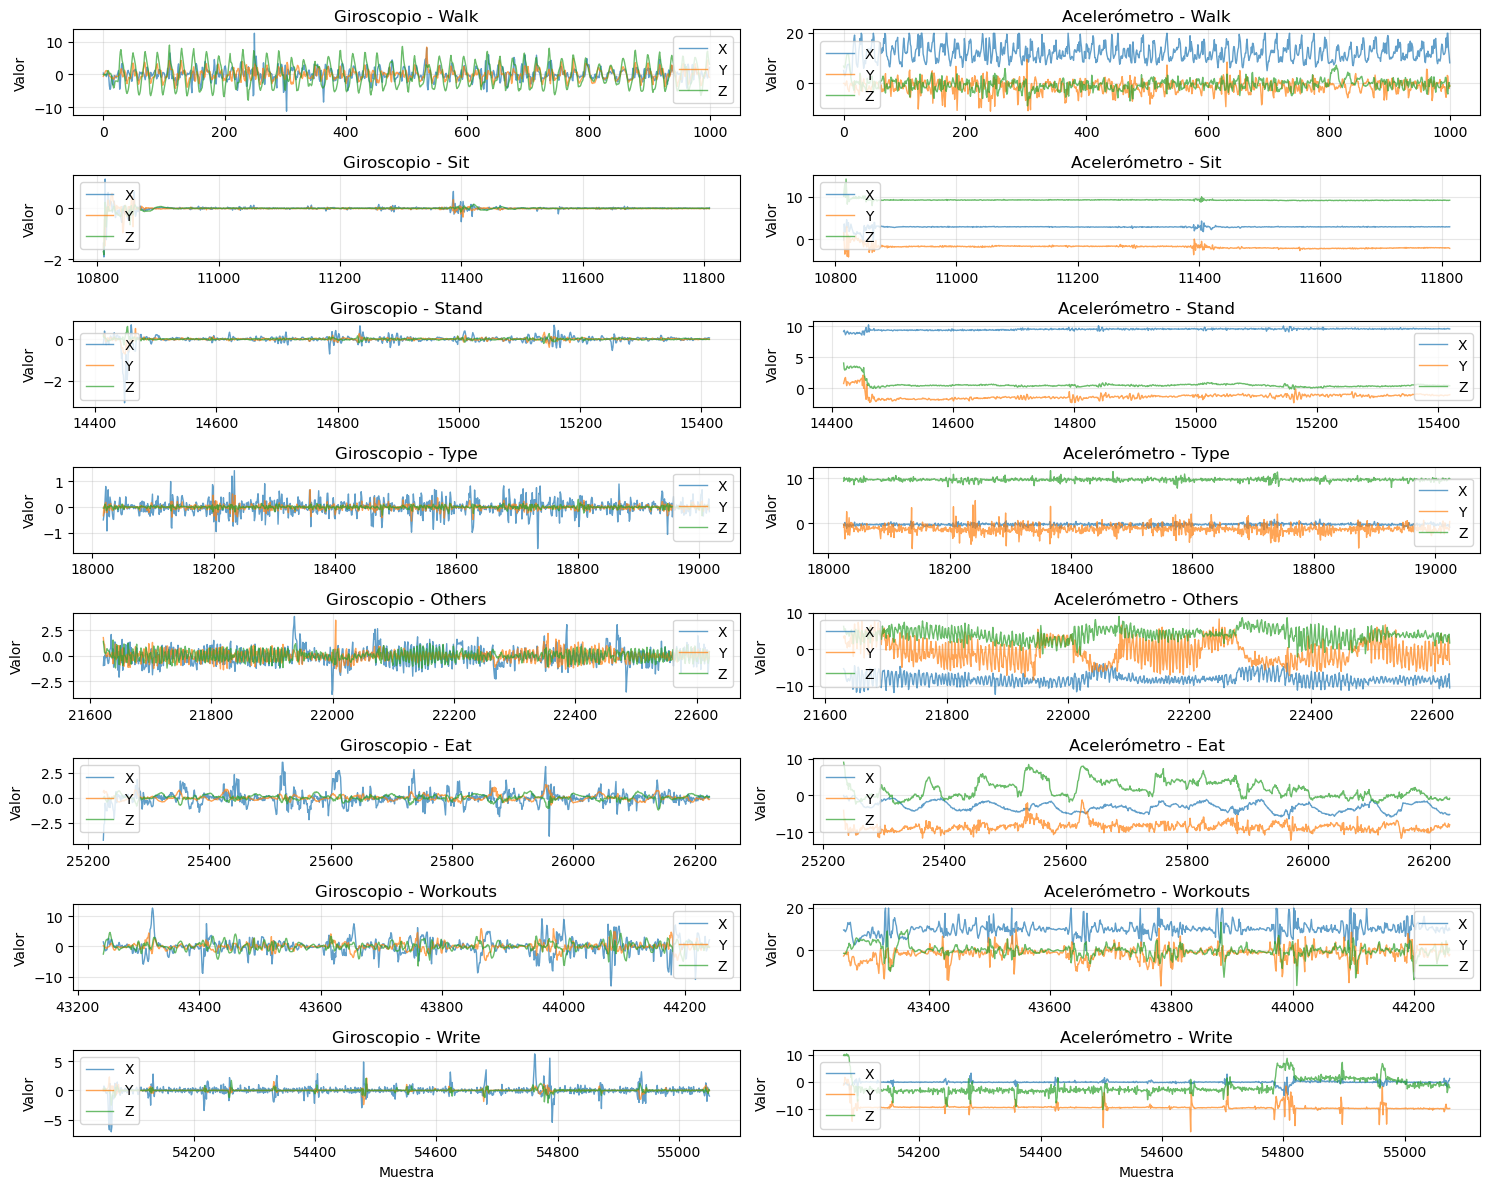

In [91]:
def plot_axes_by_activity(df_gyro, df_accel, max_samples_per_activity=1000, figsize=(15, 12), id_user : float = 1600.0):
    """
    Visualiza los ejes X, Y, Z del giroscopio y acelerómetro por cada actividad
    """

    df_gyro     = df_gyro[df_gyro['Subject-id']     ==      id_user]
    df_accel    = df_accel[df_accel['Subject-id']   ==      id_user]

    # Obtener actividades únicas
    activities = df_gyro['Activity Label'].unique().tolist()
    n_activities = len(activities)
    
    # Crear subplots
    fig, axes = plt.subplots(n_activities, 2, figsize=figsize)
    if n_activities == 1:
        axes = axes.reshape(1, -1)
    
    for i, activity in enumerate(activities):
        # Filtrar datos por actividad
        gyro_activity = df_gyro[df_gyro['Activity Label'] == activity]
        accel_activity =  df_accel[df_accel['Activity Label'] == activity]
        
        # Limitar muestras para mejor visualización
        if len(gyro_activity) > max_samples_per_activity:
            gyro_activity = gyro_activity.head(max_samples_per_activity)
        if len(accel_activity) > max_samples_per_activity:
            accel_activity = accel_activity.head(max_samples_per_activity)
        
        # Convertir a pandas para plotting
        gyro_pd = gyro_activity.copy()
        accel_pd = accel_activity.copy()
        
        # Plot Giroscopio
        axes[i, 0].plot(gyro_pd['X'], label='X', alpha=0.7, linewidth=1)
        axes[i, 0].plot(gyro_pd['Y'], label='Y', alpha=0.7, linewidth=1)
        axes[i, 0].plot(gyro_pd['Z'], label='Z', alpha=0.7, linewidth=1)
        axes[i, 0].set_title(f'Giroscopio - {activity}')
        axes[i, 0].set_ylabel('Valor')
        axes[i, 0].legend()
        axes[i, 0].grid(True, alpha=0.3)
        
        # Plot Acelerómetro
        axes[i, 1].plot(accel_pd['X'], label='X', alpha=0.7, linewidth=1)
        axes[i, 1].plot(accel_pd['Y'], label='Y', alpha=0.7, linewidth=1)
        axes[i, 1].plot(accel_pd['Z'], label='Z', alpha=0.7, linewidth=1)
        axes[i, 1].set_title(f'Acelerómetro - {activity}')
        axes[i, 1].set_ylabel('Valor')
        axes[i, 1].legend()
        axes[i, 1].grid(True, alpha=0.3)
        
        # Añadir xlabel solo en la última fila
        if i == n_activities - 1:
            axes[i, 0].set_xlabel('Muestra')
            axes[i, 1].set_xlabel('Muestra')
    
    plt.tight_layout()
    plt.show()

# Ejecutar visualización
plot_axes_by_activity(df_gyro, df_accel)

In [169]:
df_accel = pl.DataFrame(df_accel).sort(['Subject-id', 'Activity Label', 'Timestamp'])
df_gyro = pl.DataFrame(df_gyro).sort(['Subject-id', 'Activity Label', 'Timestamp'])

In [170]:
# Extraer características con diferentes sobrelapamientos
print("Extrayendo características...")

features_50_accel = create_feature_windows(pl.DataFrame(df_accel), window_seconds=5, overlap_percent=50)
# features_50_gyro = create_feature_windows(pl.DataFrame(df_gyro), window_seconds=5, overlap_percent=50)

Extrayendo características...


In [7]:
# Extraer características con diferentes sobrelapamientos
print("Extrayendo características...")

features_50_accel = create_feature_windows(df_accel_inner, window_seconds=5, overlap_percent=50)
features_50_gyro = create_feature_windows(df_gyro_inner, window_seconds=5, overlap_percent=50)

Extrayendo características...


In [ ]:
# features_50_accel.to_csv(r'./data/preprocess/accel_only_wisdm_50%-overlaping_5s-windows.csv', index = False)
# features_50_gyro.to_csv(r'./data/preprocess/gyro_50%-overlaping_5s-windows.csv', index = False)

In [4]:
features_50_accel = pd.read_csv(r'./data/preprocess/accel_only_wisdm_50%-overlaping_5s-windows.csv')
features_50_gyro = pd.read_csv(r'./data/preprocess/gyro_50%-overlaping_5s-windows.csv')

In [141]:
features_combined = pd.merge(
    features_50_gyro,
    features_50_accel, 
    on=['Subject-id', 'Activity Label', 'window_start', 'window_end', 'sample_count'], 
    how="inner"
)

In [10]:
with open(r'F:\UPC\Tesis\HARbit-Model\src\config\activities.yaml', 'r') as file:
    config = yaml.safe_load(file)['config']

In [11]:
activities_ = config['labels'] 
cluster_ = config['clusters']

In [ ]:
features_combined['Activity Label'] = features_combined['Activity Label'].apply(lambda x: activities_[x])

In [145]:
for activity in cluster_.keys():
    for act in cluster_[activity]:
        features_combined.loc[features_combined['Activity Label'] == act, 'Activity Label'] = activity

In [146]:
ls_columns_gyro = [col for col in features_combined.columns if col.endswith('_x')]
ls_columns_accel = [col for col in features_combined.columns if col.endswith('_y')]

In [147]:
features_combined_without_sensor = features_combined.drop(columns = ls_columns_gyro)

In [6]:
loso_results = loso_cross_validation(
    features_combined = features_50_accel,
    model_architecture_func = create_cnn_lstm_model,
    model_params={},
    group_size=5,
    step_size=1,
    epochs=30,  # Reducir para pruebas
    batch_size=32,
    verbose=1,
    save_results=True,
    results_path="loso_uci_har"
)


🚀 INICIANDO LOSO CROSS-VALIDATION
👥 Total de usuarios: 51
📊 Usuarios: [1600. 1601. 1602. 1603. 1604. 1605. 1606. 1607. 1608. 1609. 1610. 1611.
 1612. 1613. 1614. 1615. 1616. 1617. 1618. 1619. 1620. 1621. 1622. 1623.
 1624. 1625. 1626. 1627. 1628. 1629. 1630. 1631. 1632. 1633. 1634. 1635.
 1636. 1637. 1638. 1639. 1640. 1641. 1642. 1643. 1644. 1645. 1646. 1647.
 1648. 1649. 1650.]

🔄 FOLD 1/51: Usuario de test = 1600.0
----------------------------------------
📊 Train: 63429 muestras de 50 usuarios
📊 Test: 1277 muestras del usuario 1600.0
✅ Secuencias creadas: (61833, 5, 68)
  Num features: 68
  Clases: ['Eat' 'Others' 'Sit' 'Stand' 'Type' 'Walk' 'Workouts' 'Write']
✅ Secuencias creadas: (1245, 5, 68)
  Num features: 68
  Clases: ['Eat' 'Others' 'Sit' 'Stand' 'Type' 'Walk' 'Workouts' 'Write']
🎯 Clases en train: ['Eat', 'Others', 'Sit', 'Stand', 'Type', 'Walk', 'Workouts', 'Write']
🎯 Clases en test: ['Eat', 'Others', 'Sit', 'Stand', 'Type', 'Walk', 'Workouts', 'Write']
🎯 Clases comunes: ['

KeyboardInterrupt: 

In [ ]:
if loso_results:
    print(f"✅ LOSO completado exitosamente!")
    print(f"📊 Accuracy promedio: {loso_results['mean_accuracy']:.4f}")
    print(f"📊 Std Accuracy: {loso_results['std_accuracy']:.4f}")
    
    # Visualizar
    visualize_loso_results(loso_results)

In [ ]:
data_train, data_test, data_val = split_by_user(features_50_accel, num_user_test = 3, num_user_val = 3)

In [185]:
X_train, y_train, subjects, label_encoder = prepare_features_for_cnn_lstm_sequences(
    data_train,
    group_size = 8, 
    step_size = 1
)

num_classes = len(label_encoder.classes_)
y_train = label_encoder.inverse_transform(y_train)

✅ Secuencias creadas: (50747, 8, 68)
  Num features: 68
  Clases: ['Eat' 'Others' 'Sit' 'Stand' 'Type' 'Walk' 'Workouts' 'Write']


In [186]:
X_test, y_test, _, le = prepare_features_for_cnn_lstm_sequences(
    data_test,
    group_size = 8, 
    step_size = 1
)

y_test = le.inverse_transform(y_test)

✅ Secuencias creadas: (3658, 8, 68)
  Num features: 68
  Clases: ['Eat' 'Others' 'Sit' 'Stand' 'Type' 'Walk' 'Workouts' 'Write']


In [187]:
X_val, y_val, _, le = prepare_features_for_cnn_lstm_sequences(
    data_val,
    group_size = 8,
    step_size = 1
)

y_val = le.inverse_transform(y_val)

✅ Secuencias creadas: (3522, 8, 68)
  Num features: 68
  Clases: ['Eat' 'Others' 'Sit' 'Stand' 'Type' 'Walk' 'Workouts' 'Write']


In [179]:
from models.main import *
input_shape = (X_train.shape[1], X_train.shape[2])


model = create_cnn_lstm_model(input_shape = input_shape, num_classes = num_classes)

c:\Users\HP\miniconda3\envs\forecasting\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Entrenar modelo
print("Entrenando modelo CNN-LSTM...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

In [188]:
from tensorflow import keras

model = keras.models.load_model(r'F:\UPC\Tesis\HARbit-Model\src\models\version\sensors\accel_cnn-lstm_wisdm_91_cluster_user.h5')
label_encoder = joblib.load(r'F:\UPC\Tesis\HARbit-Model\src\models\meta\sensors\accel_cnn-lstm_wisdm_91_cluster_user.joblib')

In [189]:
y_train = label_encoder.transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

Evaluando modelo...
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step

Pérdida en test: 0.3243
Precisión en test: 0.9040

REPORTE DE CLASIFICACIÓN
              precision    recall  f1-score   support

         Eat     0.9161    0.9232    0.9196      1041
      Others     0.9133    0.9951    0.9525       614
         Sit     0.8312    0.3333    0.4758       192
       Stand     0.7652    0.9167    0.8341       192
        Type     0.9143    0.6667    0.7711       192
        Walk     0.9752    0.9531    0.9640       618
    Workouts     0.9459    0.9643    0.9551       617
       Write     0.7038    0.9531    0.8097       192

    accuracy                         0.9040      3658
   macro avg     0.8706    0.8382    0.8352      3658
weighted avg     0.9070    0.9040    0.8973      3658



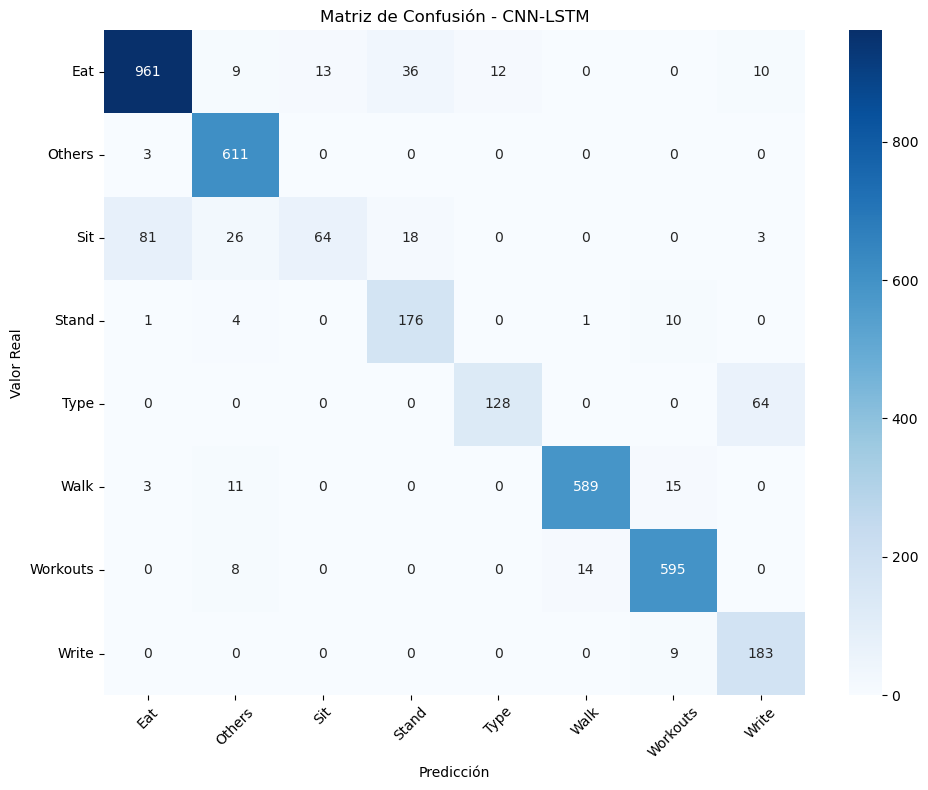

In [190]:
print("Evaluando modelo...")

# Predicciones
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Métricas básicas
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nPérdida en test: {test_loss:.4f}")
print(f"Precisión en test: {test_accuracy:.4f}")

# Reporte de clasificación detallado
print("\n" + "="*50)
print("REPORTE DE CLASIFICACIÓN")
print("="*50)
print(classification_report(
    y_test, 
    y_pred_classes, 
    target_names=label_encoder.classes_,
    digits=4
))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Matriz de Confusión - CNN-LSTM')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [113]:
model.save(r'F:\UPC\Tesis\HARbit-Model\src\models\version\sensors\accel_cnn-lstm_wisdm_91_cluster_user.h5')
joblib.dump(label_encoder, r'F:\UPC\Tesis\HARbit-Model\src\models\meta\sensors\accel_cnn-lstm_wisdm_91_cluster_user.joblib')

['F:\\UPC\\Tesis\\HARbit-Model\\src\\models\\meta\\sensors\\accel_cnn-lstm_wisdm_91_cluster_user.joblib']

In [46]:
# ==============================================
# ANÁLISIS COMPLETO DE OVERFITTING PARA SECUENCIAS
# ==============================================
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

def analyze_overfitting(model, X_train, y_train, X_test, y_test, label_encoder):
    """
    Análisis completo de overfitting comparando train vs test
    para entradas con forma (N, timesteps, features)
    """
    print("🔍 ANÁLISIS DE OVERFITTING")
    print("="*60)
    
    # Evaluar en datos de entrenamiento
    print("📊 Evaluando en datos de ENTRENAMIENTO...")
    train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    train_pred = model.predict(X_train, verbose=0)
    train_pred_classes = np.argmax(train_pred, axis=1)
    
    # Evaluar en datos de test
    print("📊 Evaluando en datos de TEST...")
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    test_pred = model.predict(X_test, verbose=0)
    test_pred_classes = np.argmax(test_pred, axis=1)
    
    # Comparar métricas
    print(f"\n📈 COMPARACIÓN TRAIN vs TEST:")
    print(f"{'Métrica':<20} {'Train':<10} {'Test':<10} {'Diferencia':<12} {'Overfitting'}")
    print("-" * 65)
    
    # Accuracy
    acc_diff = train_accuracy - test_accuracy
    acc_overfitting = "⚠️ SÍ" if acc_diff > 0.1 else "✅ NO"
    print(f"{'Accuracy':<20} {train_accuracy:<10.4f} {test_accuracy:<10.4f} {acc_diff:<12.4f} {acc_overfitting}")
    
    # Loss
    loss_diff = test_loss - train_loss
    loss_overfitting = "⚠️ SÍ" if loss_diff > 0.5 else "✅ NO"
    print(f"{'Loss':<20} {train_loss:<10.4f} {test_loss:<10.4f} {loss_diff:<12.4f} {loss_overfitting}")
    
    # Métricas por clase
    train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
        y_train, train_pred_classes, average='macro'
    )
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
        y_test, test_pred_classes, average='macro'
    )
    
    # Precision
    prec_diff = train_precision - test_precision
    prec_overfitting = "⚠️ SÍ" if prec_diff > 0.1 else "✅ NO"
    print(f"{'Precision (macro)':<20} {train_precision:<10.4f} {test_precision:<10.4f} {prec_diff:<12.4f} {prec_overfitting}")
    
    # Recall
    rec_diff = train_recall - test_recall
    rec_overfitting = "⚠️ SÍ" if rec_diff > 0.1 else "✅ NO"
    print(f"{'Recall (macro)':<20} {train_recall:<10.4f} {test_recall:<10.4f} {rec_diff:<12.4f} {rec_overfitting}")
    
    # F1-Score
    f1_diff = train_f1 - test_f1
    f1_overfitting = "⚠️ SÍ" if f1_diff > 0.1 else "✅ NO"
    print(f"{'F1-Score (macro)':<20} {train_f1:<10.4f} {test_f1:<10.4f} {f1_diff:<12.4f} {f1_overfitting}")
    
    # Diagnóstico general
    overfitting_indicators = [
        acc_diff > 0.1, loss_diff > 0.5, prec_diff > 0.1, 
        rec_diff > 0.1, f1_diff > 0.1
    ]
    
    print(f"\n🎯 DIAGNÓSTICO GENERAL:")
    if sum(overfitting_indicators) >= 3:
        print("❌ MODELO CON OVERFITTING SEVERO")
    elif sum(overfitting_indicators) >= 2:
        print("⚠️ MODELO CON OVERFITTING MODERADO")
    elif sum(overfitting_indicators) == 1:
        print("🔶 MODELO CON OVERFITTING LEVE")
    else:
        print("✅ MODELO SIN OVERFITTING SIGNIFICATIVO")
    
    return {
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_loss': train_loss,
        'test_loss': test_loss,
        'overfitting_score': sum(overfitting_indicators)
    }


In [47]:
print("🔄 Preparando datos para análisis de overfitting...")

# Crear secuencias con dependencia temporal
X_all, y_all, subjects, label_encoder = prepare_features_for_cnn_lstm_sequences(
    features_combined,
    group_size=10,  # longitud de la secuencia
    step_size=1
)

# División estratificada
X_temp, X_test_split, y_temp, y_test_split = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"✅ División de datos:")
print(f"  Train: {X_train_split.shape[0]} muestras")
print(f"  Validation: {X_val_split.shape[0]} muestras") 
print(f"  Test: {X_test_split.shape[0]} muestras")

# Analizar overfitting
overfitting_results = analyze_overfitting(
    model, X_train_split, y_train_split, X_test_split, y_test_split, label_encoder
)


🔄 Preparando datos para análisis de overfitting...
✅ Secuencias creadas: (57135, 10, 136)
  Num features: 136
  Clases: ['Eat' 'Others' 'Sit' 'Stand' 'Type' 'Walk' 'Workouts' 'Write']
✅ División de datos:
  Train: 34281 muestras
  Validation: 11427 muestras
  Test: 11427 muestras
🔍 ANÁLISIS DE OVERFITTING
📊 Evaluando en datos de ENTRENAMIENTO...
📊 Evaluando en datos de TEST...

📈 COMPARACIÓN TRAIN vs TEST:
Métrica              Train      Test       Diferencia   Overfitting
-----------------------------------------------------------------
Accuracy             0.9346     0.9338     0.0008       ✅ NO
Loss                 0.2140     0.2175     0.0035       ✅ NO
Precision (macro)    0.8898     0.8927     -0.0029      ✅ NO
Recall (macro)       0.9036     0.9086     -0.0050      ✅ NO
F1-Score (macro)     0.8933     0.8972     -0.0039      ✅ NO

🎯 DIAGNÓSTICO GENERAL:
✅ MODELO SIN OVERFITTING SIGNIFICATIVO


In [14]:
joblib.dump(label_encoder, r'./models/config/label_encoder.joblib')

['./models/config/label_encoder.joblib']


MÉTRICAS POR CLASE
   Actividad  Precisión  Recall  F1-Score  Soporte
0          A     0.8401  0.8276    0.8338      673
1          B     0.9775  0.9879    0.9826      659
2          C     0.8066  0.7383    0.7709      661
3          D     0.7486  0.7725    0.7603      690
4          E     0.8293  0.8499    0.8395      686
5          F     0.8830  0.9479    0.9143      653
6          G     0.9703  0.9575    0.9638      682
7          H     0.7123  0.7732    0.7415      679
8          I     0.5545  0.6270    0.5886      681
9          J     0.6962  0.6799    0.6880      681
10         K     0.6676  0.6715    0.6696      688
11         L     0.4317  0.2084    0.2811      667
12         M     0.8685  0.8930    0.8806      673
13         O     0.9365  0.9407    0.9386      658
14         P     0.9877  0.9481    0.9675      675
15         Q     0.8755  0.9604    0.9160      681
16         R     0.9866  0.9794    0.9830      678
17         S     0.7968  0.9557    0.8690      677

Precisión 

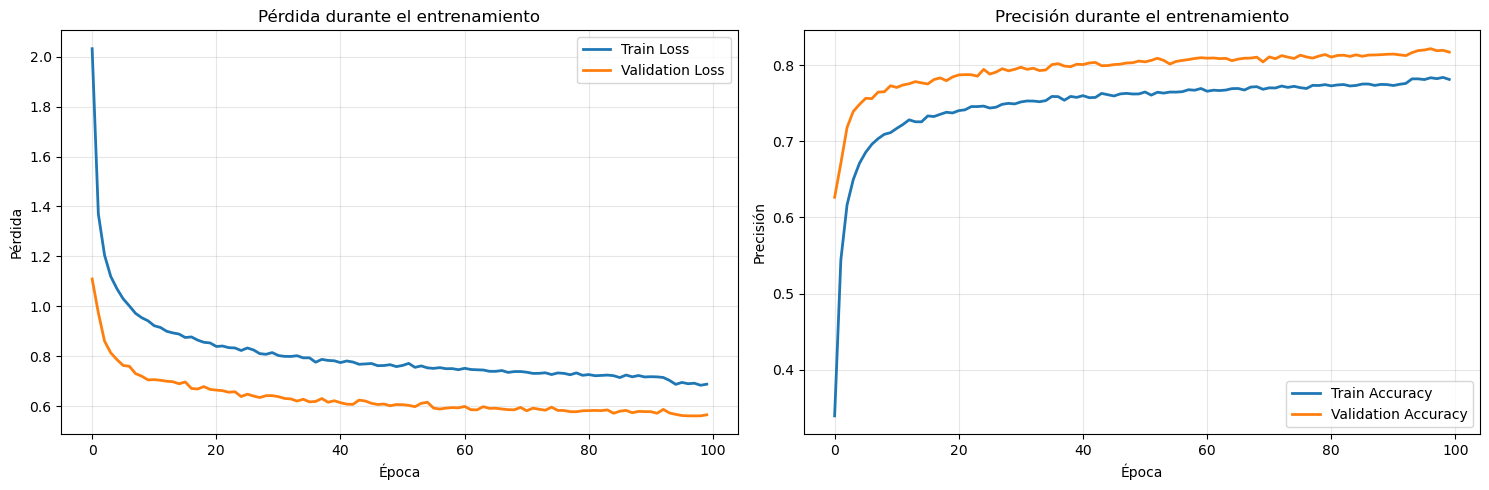


ANÁLISIS DE ERRORES POR ACTIVIDAD
   Actividad  Precisión  Errores  Total
0          A   0.827637      116    673
1          B   0.987860        8    659
2          C   0.738275      173    661
3          D   0.772464      157    690
4          E   0.849854      103    686
5          F   0.947933       34    653
6          G   0.957478       29    682
7          H   0.773196      154    679
8          I   0.627019      254    681
9          J   0.679883      218    681
10         K   0.671512      226    688
11         L   0.208396      528    667
12         M   0.893016       72    673
13         O   0.940729       39    658
14         P   0.948148       35    675
15         Q   0.960352       27    681
16         R   0.979351       14    678
17         S   0.955687       30    677


In [ ]:
# Métricas por clase
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_classes, average=None)

# Crear DataFrame con métricas por clase
metrics_df = pd.DataFrame({
    'Actividad': label_encoder.classes_,
    'Precisión': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Soporte': support
})

print("\n" + "="*60)
print("MÉTRICAS POR CLASE")
print("="*60)
print(metrics_df.round(4))

# Métricas globales adicionales
print(f"\nPrecisión promedio (macro): {precision.mean():.4f}")
print(f"Recall promedio (macro): {recall.mean():.4f}")
print(f"F1-Score promedio (macro): {f1.mean():.4f}")
print(f"Precisión balanceada: {balanced_accuracy_score(y_test, y_pred_classes):.4f}")

# Curvas de entrenamiento
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Pérdida
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Pérdida durante el entrenamiento')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Pérdida')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Precisión
axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_title('Precisión durante el entrenamiento')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Precisión')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis de errores por actividad
error_analysis = []
for i, activity in enumerate(label_encoder.classes_):
    mask = y_test == i
    if mask.sum() > 0:
        activity_accuracy = accuracy_score(y_test[mask], y_pred_classes[mask])
        error_analysis.append({
            'Actividad': activity,
            'Precisión': activity_accuracy,
            'Errores': (y_test[mask] != y_pred_classes[mask]).sum(),
            'Total': mask.sum()
        })

error_df = pd.DataFrame(error_analysis)
print("\n" + "="*50)
print("ANÁLISIS DE ERRORES POR ACTIVIDAD")
print("="*50)
print(error_df)

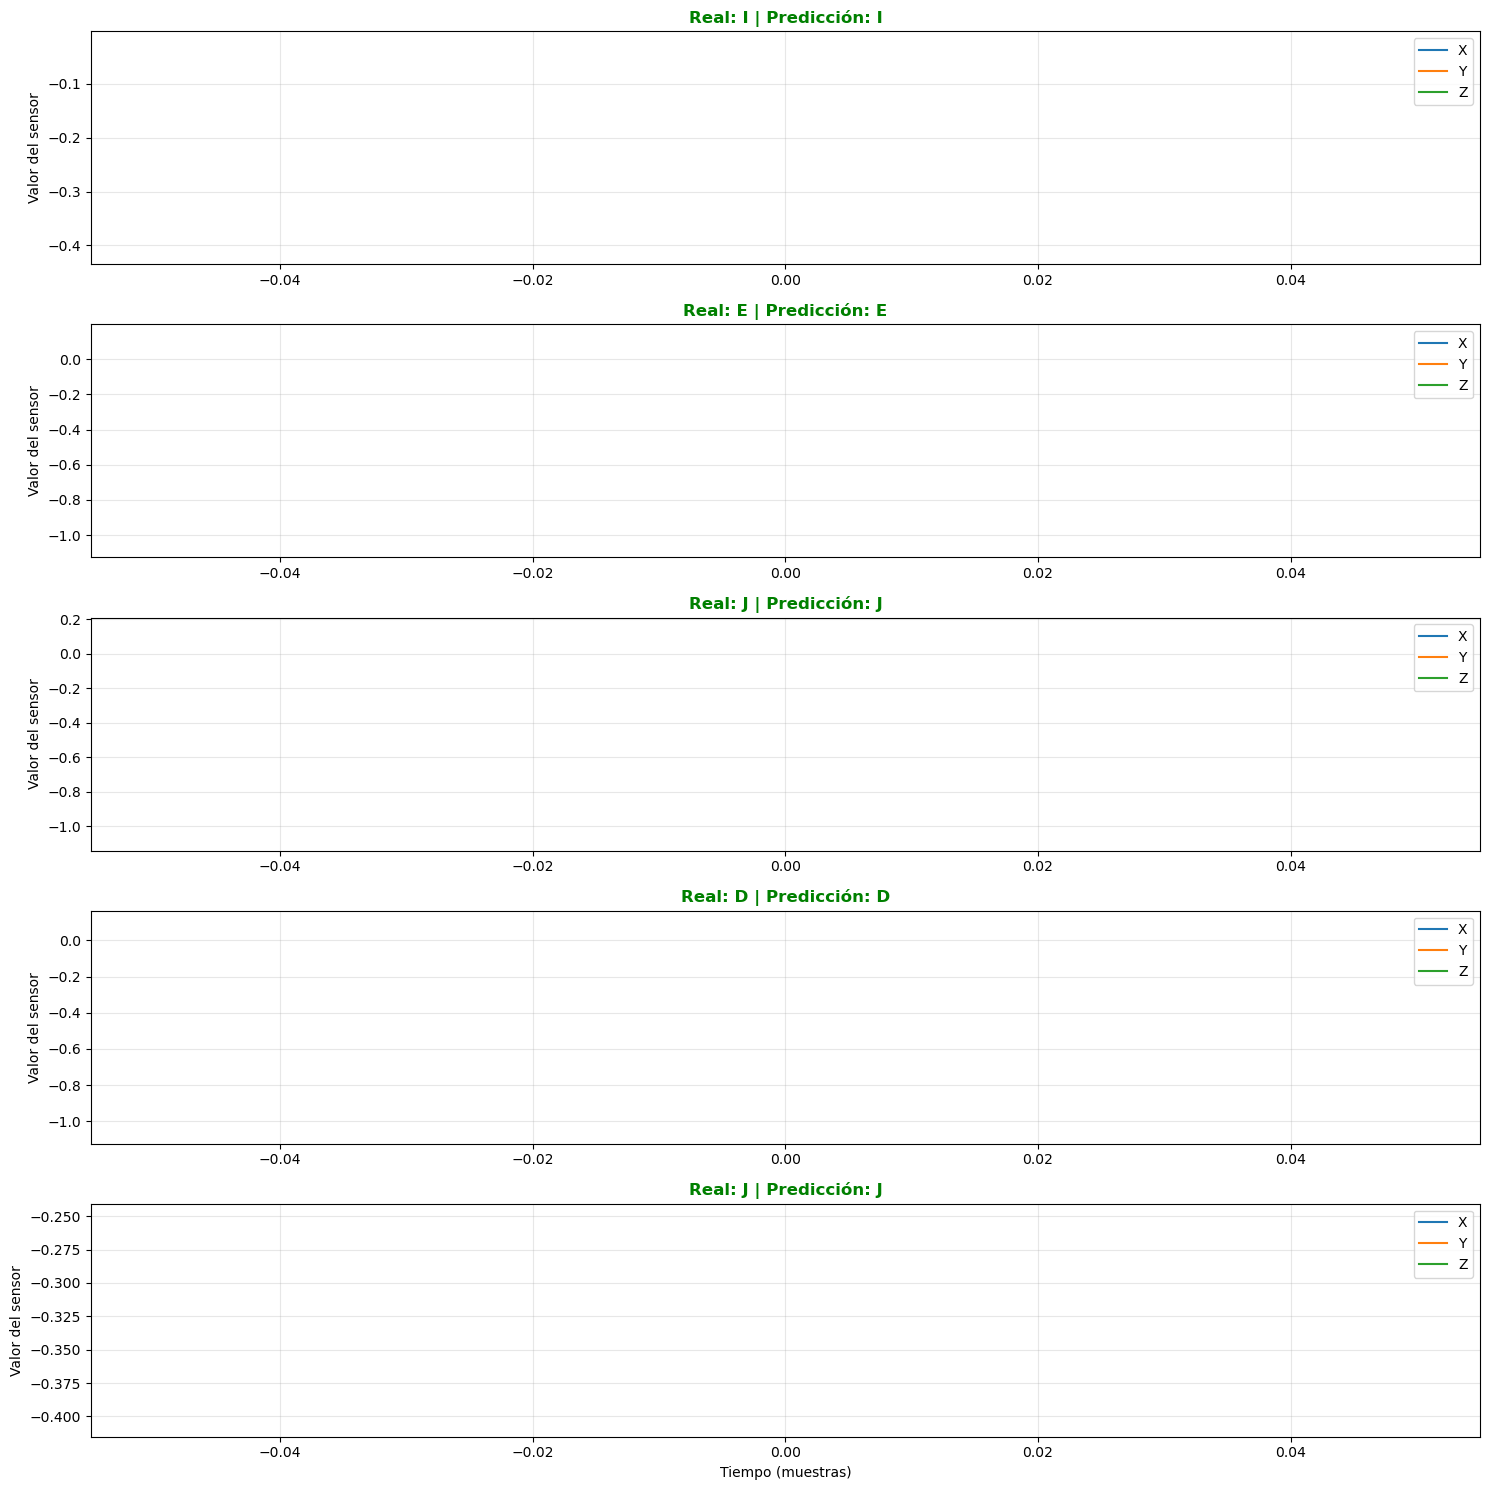


Resumen del modelo:
- Arquitectura: CNN-LSTM
- Ventana temporal: 1 muestras
- Características: 136 ejes (X, Y, Z)
- Clases: 18
- Precisión final: 0.8174
- Muestras de entrenamiento: 36426
- Muestras de test: 12142


In [21]:
def plot_prediction_examples(X_test, y_test, y_pred_classes, label_encoder, n_examples=5):
    """
    Muestra ejemplos de predicciones vs valores reales
    """
    fig, axes = plt.subplots(n_examples, 1, figsize=(15, 3*n_examples))
    
    # Seleccionar ejemplos aleatorios
    indices = np.random.choice(len(X_test), n_examples, replace=False)
    
    for i, idx in enumerate(indices):
        # Datos de la muestra
        sample = X_test[idx]
        true_label = label_encoder.classes_[y_test[idx]]
        pred_label = label_encoder.classes_[y_pred_classes[idx]]
        
        # Graficar las tres dimensiones
        axes[i].plot(sample[:, 0], label='X', linewidth=1.5)
        axes[i].plot(sample[:, 1], label='Y', linewidth=1.5)
        axes[i].plot(sample[:, 2], label='Z', linewidth=1.5)
        
        # Título con predicción
        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f'Real: {true_label} | Predicción: {pred_label}', 
                         color=color, fontweight='bold')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
        axes[i].set_ylabel('Valor del sensor')
        
        if i == n_examples - 1:
            axes[i].set_xlabel('Tiempo (muestras)')
    
    plt.tight_layout()
    plt.show()

# Mostrar ejemplos de predicciones
plot_prediction_examples(X_test, y_test, y_pred_classes, label_encoder, n_examples=5)

print(f"\nResumen del modelo:")
print(f"- Arquitectura: CNN-LSTM")
print(f"- Ventana temporal: {X_train.shape[1]} muestras")
print(f"- Características: {X_train.shape[2]} ejes (X, Y, Z)")
print(f"- Clases: {num_classes}")
print(f"- Precisión final: {test_accuracy:.4f}")
print(f"- Muestras de entrenamiento: {len(X_train)}")
print(f"- Muestras de test: {len(X_test)}")

Todos los modelos deben de guardarse con el siguiente formato:

**{nombre del modelo}_har_model_{precision}.h5**

Antes de ello, es importante revisar el rendimiento del modelo multiclase, así que no solo nos debemos de basar en la precision (accuracy), sino en el recall para tener en cuenta un posible desbalance entre clases en caso se presente el caso.

In [22]:
# Guardar modelo
model.save('./models/cnn-lstm_har_model_82.h5')
print("Modelo guardado como 'cnn-lstm_har_model_82.h5'")

Modelo guardado como 'cnn-lstm_har_model_82.h5'


In [9]:
def create_raw_windows_250_timesteps_robust(df, window_seconds=5, overlap_percent=50, 
                                           sampling_rate=20, target_timesteps=250,
                                           min_data_threshold=0.5, max_gap_seconds=1.0):
    """
    Versión ROBUSTA: Crea ventanas basadas en TIEMPO REAL con validación mejorada
    
    Args:
        df: DataFrame con datos de sensores (Polars o Pandas)
        window_seconds: Duración de la ventana en segundos (default: 5)
        overlap_percent: Porcentaje de solapamiento (default: 50)
        sampling_rate: Frecuencia de muestreo en Hz (default: 20)
        target_timesteps: Número objetivo de timesteps por ventana (default: 250)
        min_data_threshold: Umbral mínimo de datos válidos (0.5 = 50%)
        max_gap_seconds: Máximo gap permitido en segundos (1.0s)
        
    Returns:
        X: Array con forma (n_windows, 250, 3) - datos de ventanas
        y: Array con etiquetas de actividad
        subjects: Array con IDs de usuario
        metadata: DataFrame con información de las ventanas
    """
    
    print(f"🔧 Configuración de ventanas RAW ROBUSTA:")
    print(f"  Duración: {window_seconds}s")
    print(f"  Timesteps objetivo: {target_timesteps}")
    print(f"  Frecuencia de muestreo: {sampling_rate}Hz")
    print(f"  Solapamiento: {overlap_percent}%")
    print(f"  Umbral mínimo de datos: {min_data_threshold*100:.1f}%")
    print(f"  Máximo gap permitido: {max_gap_seconds}s")
    
    # Convertir a pandas si es necesario
    if hasattr(df, 'to_pandas'):
        df_pd = df.to_pandas()
    else:
        df_pd = df.copy()
    
    # Asegurar que Timestamp es datetime
    if df_pd['Timestamp'].dtype == 'object':
        df_pd['Timestamp'] = pd.to_datetime(df_pd['Timestamp'])
    elif df_pd['Timestamp'].dtype == 'int64':
        df_pd['Timestamp'] = pd.to_datetime(df_pd['Timestamp'])
    
    # Calcular parámetros de tiempo
    window_duration_ns = int(window_seconds * 1e9)
    step_duration_ns = int(window_duration_ns * (100 - overlap_percent) / 100)
    
    print(f"  Duración de ventana: {window_seconds}s")
    print(f"  Paso entre ventanas: {step_duration_ns / 1e9:.2f}s")
    
    # Listas para almacenar resultados
    X_windows = []
    y_labels = []
    subjects_list = []
    metadata_list = []
    
    total_windows_attempted = 0
    total_windows_created = 0
    
    # Procesar por usuario y actividad
    for (user_id, activity), group in df_pd.groupby(['Subject-id', 'Activity Label']):
        
        # Ordenar por timestamp y limpiar datos
        group = group.sort_values('Timestamp').reset_index(drop=True)
        group = group.dropna(subset=['X', 'Y', 'Z', 'Timestamp'])
        
        if len(group) < window_seconds * sampling_rate:
            print(f"⚠️ Usuario {user_id}, Actividad {activity}: Muy pocos datos ({len(group)} muestras)")
            continue
        
        # Convertir timestamps a nanosegundos
        if group['Timestamp'].dtype.name.startswith('datetime'):
            timestamps_ns = group['Timestamp'].astype('int64')
        else:
            timestamps_ns = group['Timestamp'].values
        
        print(f"👤 Usuario {user_id}, Actividad {activity}: {len(group)} muestras")
        
        # Obtener rango temporal
        start_time_ns = timestamps_ns.min()
        end_time_ns = timestamps_ns.max()
        total_duration_s = (end_time_ns - start_time_ns) / 1e9
        
        print(f"   Duración total: {total_duration_s:.1f}s")
        
        # Detectar y reportar gaps grandes
        time_diffs = np.diff(timestamps_ns) / 1e9  # Convertir a segundos
        large_gaps = time_diffs > max_gap_seconds
        if np.any(large_gaps):
            n_gaps = np.sum(large_gaps)
            max_gap = np.max(time_diffs)
            print(f"   ⚠️ Detectados {n_gaps} gaps > {max_gap_seconds}s (máximo: {max_gap:.1f}s)")
        
        # Crear ventanas deslizantes
        window_count = 0
        current_start_ns = start_time_ns
        
        while current_start_ns + window_duration_ns <= end_time_ns:
            total_windows_attempted += 1
            current_end_ns = current_start_ns + window_duration_ns
            
            # Filtrar datos en esta ventana temporal
            window_mask = (
                (timestamps_ns >= current_start_ns) & 
                (timestamps_ns < current_end_ns)
            )
            window_data_df = group[window_mask]
            
            # Validación de ventana
            is_valid, validation_info = validate_window_data(
                window_data_df, 
                window_seconds, 
                sampling_rate, 
                min_data_threshold,
                max_gap_seconds
            )
            
            if is_valid:
                # Extraer datos de sensores
                sensor_data = window_data_df[['X', 'Y', 'Z']].values
                window_timestamps = window_data_df['Timestamp'].values
                
                try:
                    # Redimensionar/interpolar a target_timesteps
                    resampled_window = resample_window_robust(
                        sensor_data, window_timestamps, target_timesteps, window_seconds
                    )
                    
                    # Verificar calidad final
                    if is_window_quality_good(resampled_window):
                        # Guardar datos
                        X_windows.append(resampled_window)
                        y_labels.append(activity)
                        subjects_list.append(user_id)
                        
                        # Metadata extendida
                        metadata_list.append({
                            'Subject-id': user_id,
                            'Activity Label': activity,
                            'window_start': pd.to_datetime(current_start_ns),
                            'window_end': pd.to_datetime(current_end_ns),
                            'original_samples': len(window_data_df),
                            'resampled_timesteps': target_timesteps,
                            'window_idx': window_count,
                            'actual_duration_s': window_seconds,
                            'data_coverage': validation_info['data_coverage'],
                            'max_gap_s': validation_info['max_gap'],
                            'sampling_rate_actual': validation_info['actual_rate']
                        })
                        
                        window_count += 1
                        total_windows_created += 1
                    else:
                        print(f"   ❌ Ventana {window_count}: Calidad de datos insuficiente después de interpolación")
                
                except Exception as e:
                    print(f"   ❌ Ventana {window_count}: Error en interpolación - {str(e)}")
            
            else:
                # No mostrar warning para cada ventana inválida, solo resumen
                pass
            
            # Mover al siguiente inicio de ventana
            current_start_ns += step_duration_ns
        
        print(f"  ✅ Creadas {window_count} ventanas válidas")
    
    # Resumen final
    print(f"\n📊 RESUMEN DE VALIDACIÓN:")
    print(f"  Ventanas intentadas: {total_windows_attempted}")
    print(f"  Ventanas creadas: {total_windows_created}")
    print(f"  Tasa de éxito: {(total_windows_created/total_windows_attempted)*100:.1f}%")
    
    # Convertir a arrays numpy
    if len(X_windows) > 0:
        X = np.array(X_windows)
        y = np.array(y_labels)
        subjects = np.array(subjects_list)
        metadata_df = pd.DataFrame(metadata_list)
        
        print(f"\n📊 RESULTADO FINAL (ROBUSTO):")
        print(f"  Forma de X: {X.shape}")
        print(f"  Forma de y: {y.shape}")
        print(f"  Total ventanas: {len(X)}")
        print(f"  Usuarios únicos: {len(np.unique(subjects))}")
        print(f"  Actividades únicas: {sorted(np.unique(y))}")
        
        return X, y, subjects, metadata_df
    
    else:
        print("❌ No se crearon ventanas válidas")
        return None, None, None, None


def validate_window_data(window_data_df, window_seconds, sampling_rate, 
                        min_data_threshold, max_gap_seconds):
    """
    Valida si una ventana de datos es aceptable
    
    Returns:
        bool: True si la ventana es válida
        dict: Información de validación
    """
    if len(window_data_df) == 0:
        return False, {'reason': 'empty', 'data_coverage': 0, 'max_gap': float('inf'), 'actual_rate': 0}
    
    # Calcular cobertura de datos esperada
    expected_samples = window_seconds * sampling_rate
    actual_samples = len(window_data_df)
    data_coverage = actual_samples / expected_samples
    
    # Si hay muy pocos datos
    if data_coverage < min_data_threshold:
        return False, {
            'reason': 'insufficient_data', 
            'data_coverage': data_coverage,
            'max_gap': float('inf'),
            'actual_rate': 0
        }
    
    # Calcular gaps en los datos
    if len(window_data_df) > 1:
        timestamps = pd.to_datetime(window_data_df['Timestamp'])
        time_diffs = timestamps.diff().dt.total_seconds().fillna(0)
        max_gap = time_diffs.max()
        actual_rate = len(window_data_df) / (timestamps.max() - timestamps.min()).total_seconds()
    else:
        max_gap = 0
        actual_rate = sampling_rate
    
    # Si hay gaps muy grandes
    if max_gap > max_gap_seconds:
        return False, {
            'reason': 'large_gap', 
            'data_coverage': data_coverage,
            'max_gap': max_gap,
            'actual_rate': actual_rate
        }
    
    # Verificar que no hay valores NaN o infinitos en los sensores
    sensor_data = window_data_df[['X', 'Y', 'Z']].values
    if np.any(np.isnan(sensor_data)) or np.any(np.isinf(sensor_data)):
        return False, {
            'reason': 'invalid_values',
            'data_coverage': data_coverage,
            'max_gap': max_gap,
            'actual_rate': actual_rate
        }
    
    return True, {
        'reason': 'valid',
        'data_coverage': data_coverage,
        'max_gap': max_gap,
        'actual_rate': actual_rate
    }


def resample_window_robust(sensor_data, timestamps, target_timesteps, window_seconds):
    """
    Versión robusta de remuestreo con múltiples estrategias
    """
    from scipy.interpolate import interp1d
    from scipy import signal
    
    if len(sensor_data) == 0:
        return np.zeros((target_timesteps, 3))
    
    original_timesteps = len(sensor_data)
    
    if original_timesteps == target_timesteps:
        return sensor_data.copy()
    
    if original_timesteps == 1:
        return np.tile(sensor_data[0], (target_timesteps, 1))
    
    try:
        # Estrategia 1: Interpolación temporal precisa
        if hasattr(timestamps[0], 'timestamp'):
            time_seconds = np.array([t.timestamp() for t in timestamps])
        elif isinstance(timestamps[0], pd.Timestamp):
            time_seconds = np.array([t.timestamp() for t in timestamps])
        else:
            time_seconds = timestamps.astype('int64') / 1e9
        
        # Normalizar tiempos
        time_min = time_seconds.min()
        time_max = time_seconds.max()
        
        if time_max > time_min:
            relative_times = (time_seconds - time_min) / (time_max - time_min)
        else:
            relative_times = np.linspace(0, 1, len(time_seconds))
        
        # Crear tiempos objetivo uniformes
        target_times = np.linspace(0, 1, target_timesteps)
        
        # Interpolar cada eje
        resampled_data = np.zeros((target_timesteps, 3))
        
        for axis in range(3):
            try:
                # Estrategia de interpolación según la cantidad de datos
                if original_timesteps >= target_timesteps:
                    # Downsample: usar signal.resample para preservar características
                    resampled_axis = signal.resample(sensor_data[:, axis], target_timesteps)
                else:
                    # Upsample: usar interpolación
                    if len(np.unique(relative_times)) > 1:
                        interpolator = interp1d(
                            relative_times, 
                            sensor_data[:, axis],
                            kind='cubic' if original_timesteps >= 4 else 'linear',
                            bounds_error=False,
                            fill_value='extrapolate'
                        )
                        resampled_axis = interpolator(target_times)
                    else:
                        resampled_axis = np.full(target_timesteps, sensor_data[0, axis])
                
                resampled_data[:, axis] = resampled_axis
                
            except Exception as e:
                # Fallback: interpolación lineal simple
                resampled_data[:, axis] = np.interp(
                    target_times, relative_times, sensor_data[:, axis]
                )
        
        return resampled_data
    
    except Exception as e:
        print(f"Error en remuestreo robusto: {str(e)}")
        # Último fallback: replicar la primera muestra
        return np.tile(sensor_data[0], (target_timesteps, 1))


def is_window_quality_good(resampled_window, max_std_threshold=50.0):
    """
    Verifica la calidad final de una ventana remuestreada
    """
    # Verificar NaN o infinitos
    if np.any(np.isnan(resampled_window)) or np.any(np.isinf(resampled_window)):
        return False
    
    # Verificar valores extremos (posibles errores de interpolación)
    if np.any(np.abs(resampled_window) > 1000):  # Ajustar según tus datos
        return False
    
    # Verificar varianza (datos demasiado planos pueden indicar error)
    for axis in range(resampled_window.shape[1]):
        std_axis = np.std(resampled_window[:, axis])
        if std_axis > max_std_threshold:  # Varianza excesiva
            return False
        if std_axis < 0.001:  # Datos demasiado planos
            return False
    
    return True

In [7]:
# Cargar datos
path_base = r"F:\UPC\Tesis\HARbit-Model\src\data\wisdm-dataset\raw\watch"
sensor_data = load_sensors_separately(path_base)
df_gyro = sensor_data['gyro']
# df_gyro = df_gyro.rename({'X': 'X_gyro', 'Y': 'Y_gyro', 'Z': 'Z_gyro'})

df_accel = sensor_data['accel']
# df_accel = df_accel.rename({'X': 'X_accel', 'Y': 'Y_accel', 'Z': 'Z_accel'})

print(f"Giroscopio: {len(df_gyro)} muestras")
print(f"Acelerómetro: {len(df_accel)} muestras")

2025-09-23 22:04:43.109 | INFO     | utils.data_loading:load_sensors_separately:64 - Cargando datos de gyro...
2025-09-23 22:05:01.873 | INFO     | utils.data_loading:load_sensors_separately:64 - Cargando datos de accel...


Giroscopio: 3440341 muestras
Acelerómetro: 3777045 muestras


In [13]:
y_all

array(['A', 'A', 'A', ..., 'S', 'S', 'S'], dtype='<U1')